In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Model import *

In [3]:
data = pd.read_csv('./adult.csv')
num_samples, num_features = data.shape
print("number of samples: ", num_samples)
print("number of features: ", num_features)

number of samples:  32561
number of features:  15


In [4]:
np.unique(data['income'])

array(['<=50K', '>50K'], dtype=object)

In [5]:
columns = ['workclass', 'education', 'marital.status', 'race','sex', 'income']
data = data[columns]

In [6]:
num_duplicates_before = len(data)
data.drop_duplicates(inplace=True)
num_duplicates_after = len(data)
num_duplicates_removed = num_duplicates_before - num_duplicates_after

print("Number of duplicates before dropping:", num_duplicates_before)
print("Number of duplicates after dropping:", num_duplicates_after)
print("Number of duplicates removed:", num_duplicates_removed)

Number of duplicates before dropping: 32561
Number of duplicates after dropping: 2300
Number of duplicates removed: 30261


In [7]:
data.replace('?', pd.NA, inplace=True)
data.dropna(inplace=True)
nan_values_remaining = data.isna().sum().sum()
print("Number of NaN values remaining:", nan_values_remaining)

Number of NaN values remaining: 0


In [84]:
print("Number of remaining samples: ", len(data))

Number of remaining samples:  1995


# plots before mapping

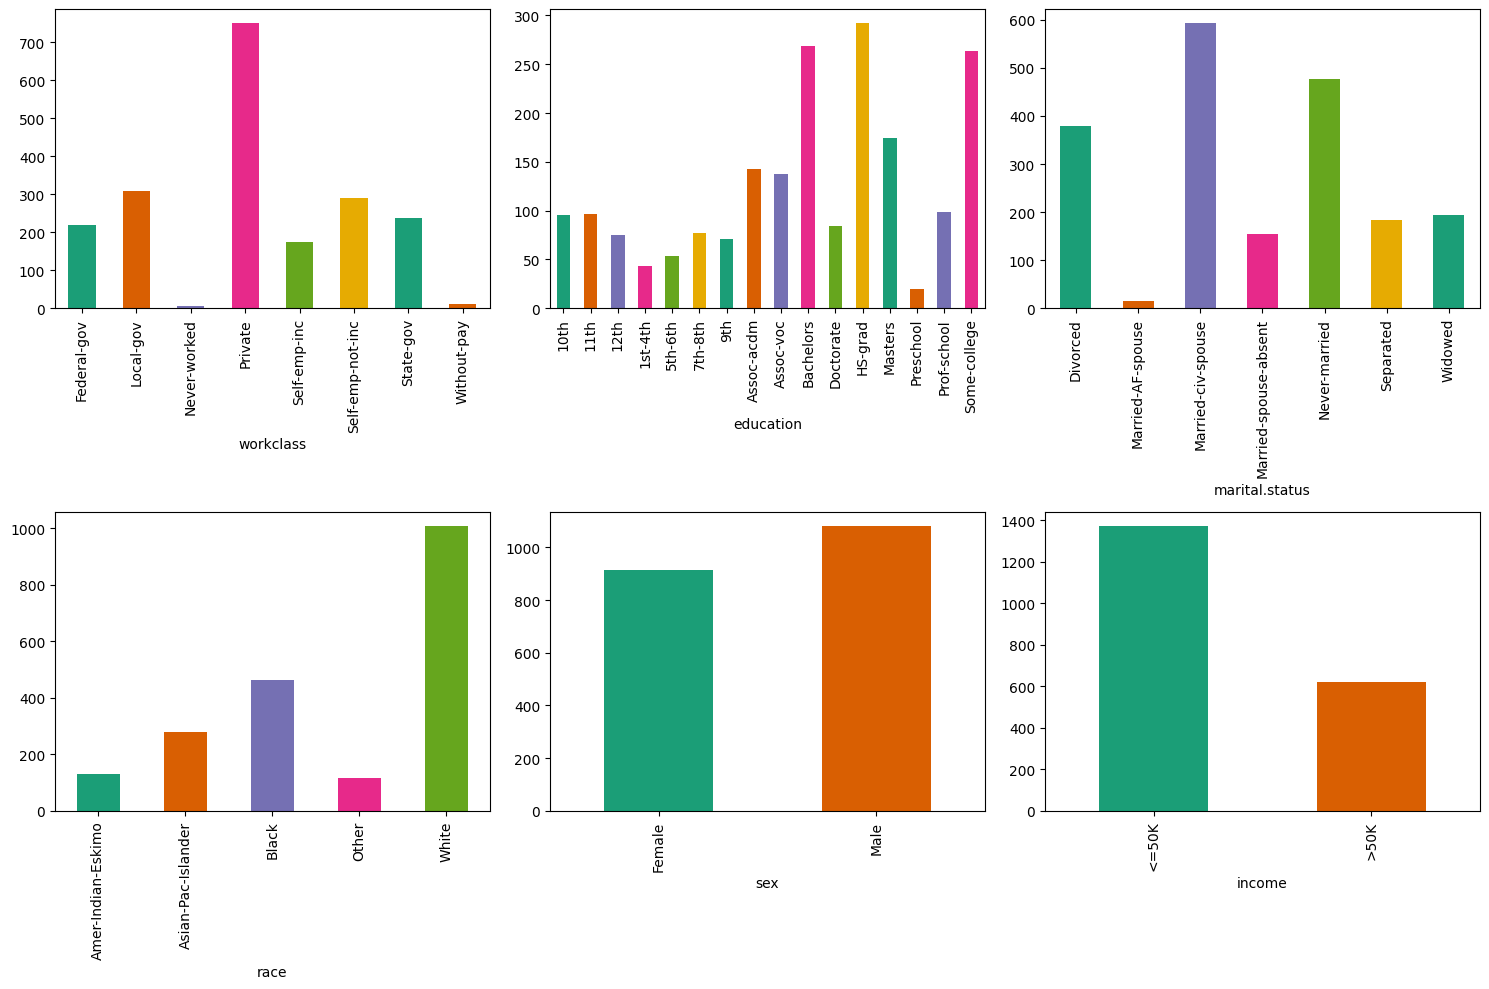

In [9]:
num_cols = min(data.shape[1], 3)
num_rows = (data.shape[1] - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
if num_rows == 1:
    axes = [axes]
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if i * num_cols + j < data.shape[1]:
            data.groupby(data.columns[i * num_cols + j]).size().plot(kind='bar', ax=ax, color=sns.palettes.mpl_palette('Dark2'))
plt.tight_layout()
plt.show()

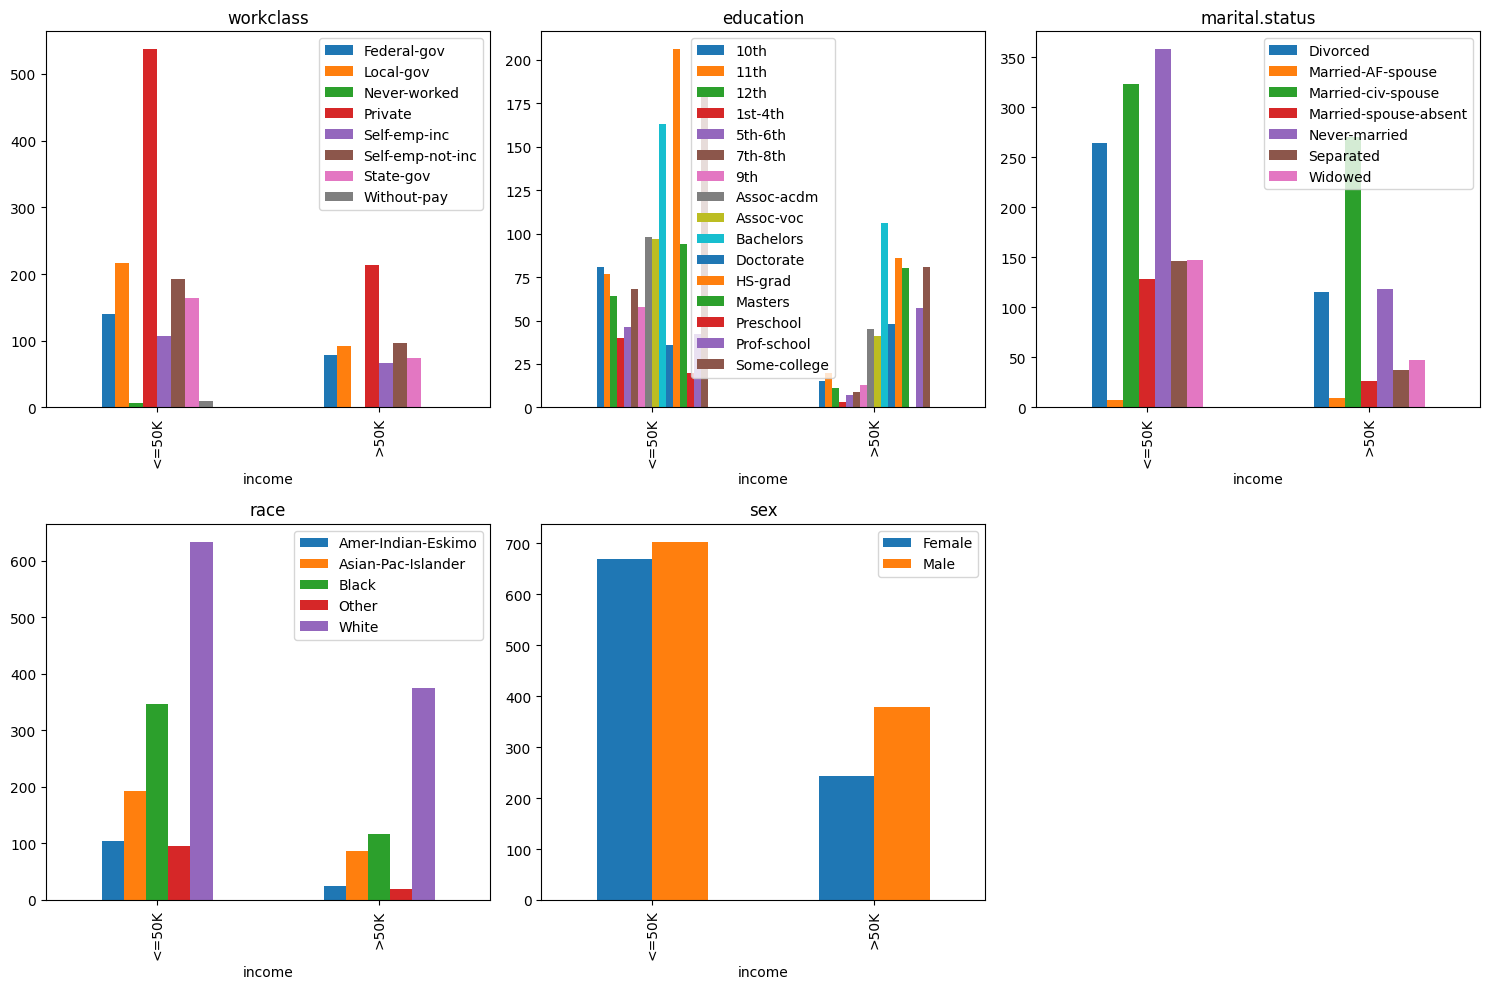

In [10]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    if i < data.shape[1] - 1:
        df_2dhist = pd.DataFrame({
            x_label: grp['income'].value_counts()
            for x_label, grp in data.groupby(data.columns[i])
        })
        df_2dhist.plot.bar(ax=ax, title=data.columns[i])

        
for i in range(data.shape[1] - 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# mapping

In [11]:
import json
with open("mappings.txt", "r") as file:
    mappings = json.load(file)

In [12]:
for column, mapping in mappings.items():
    data[column] = data[column].map(mapping)
data.replace('?', np.nan, inplace=True)
new_data = data.drop_duplicates().dropna(axis=0)

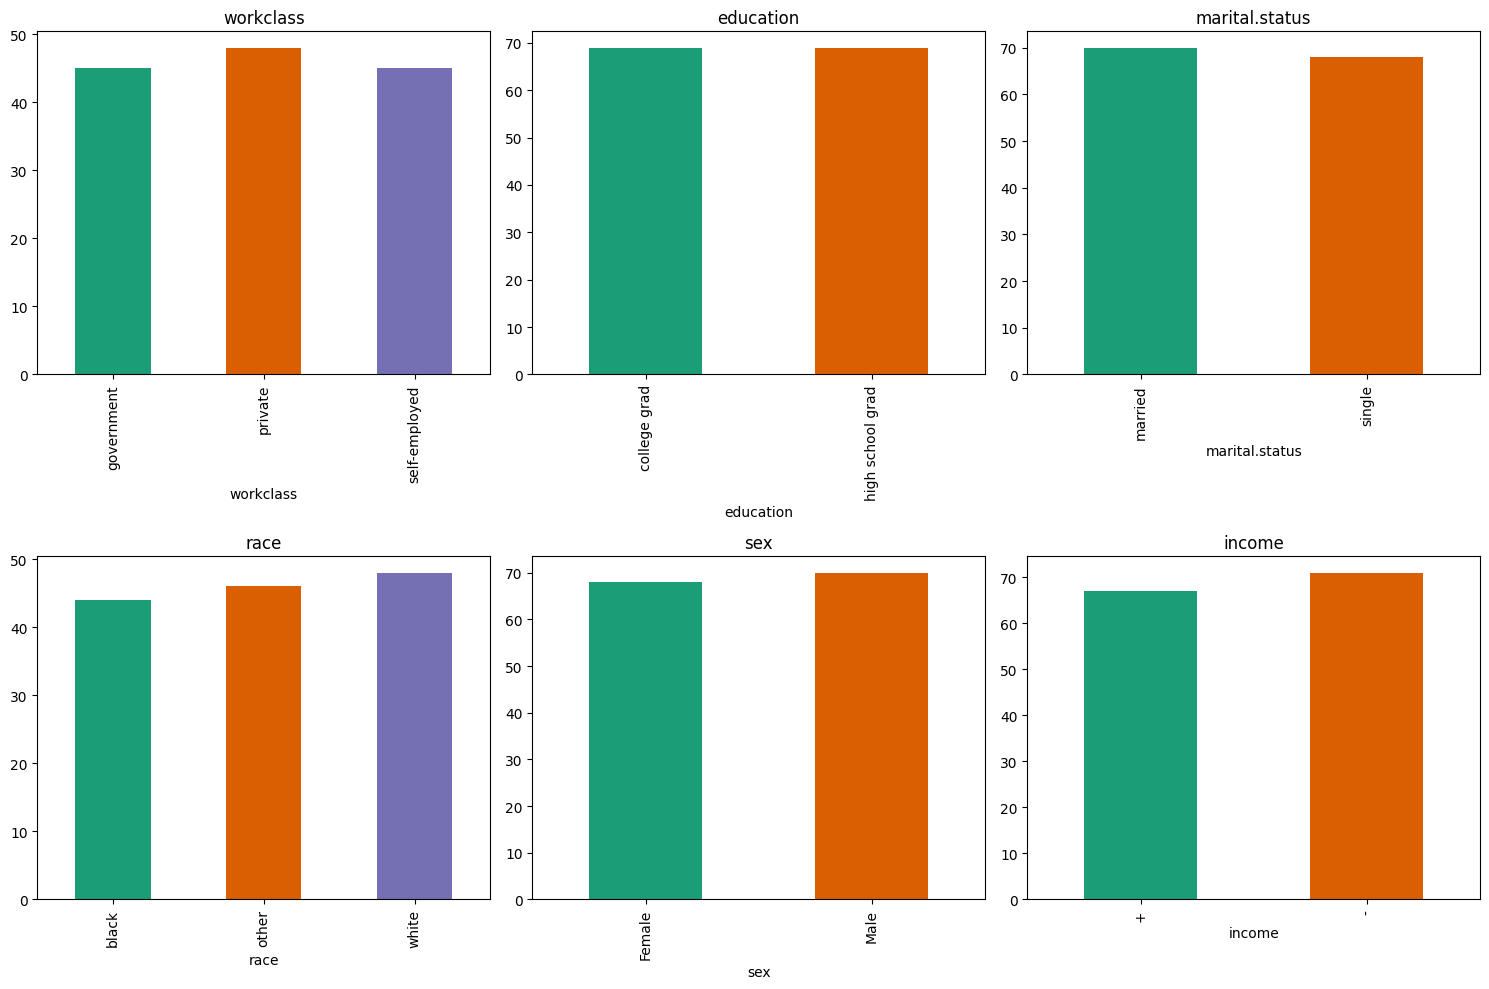

In [13]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()
for i in range(new_data.shape[1]):
    new_data.groupby(new_data.columns[i]).size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'), ax=axes[i])
    axes[i].set_title(new_data.columns[i])
for i in range(new_data.shape[1], num_rows * num_cols):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

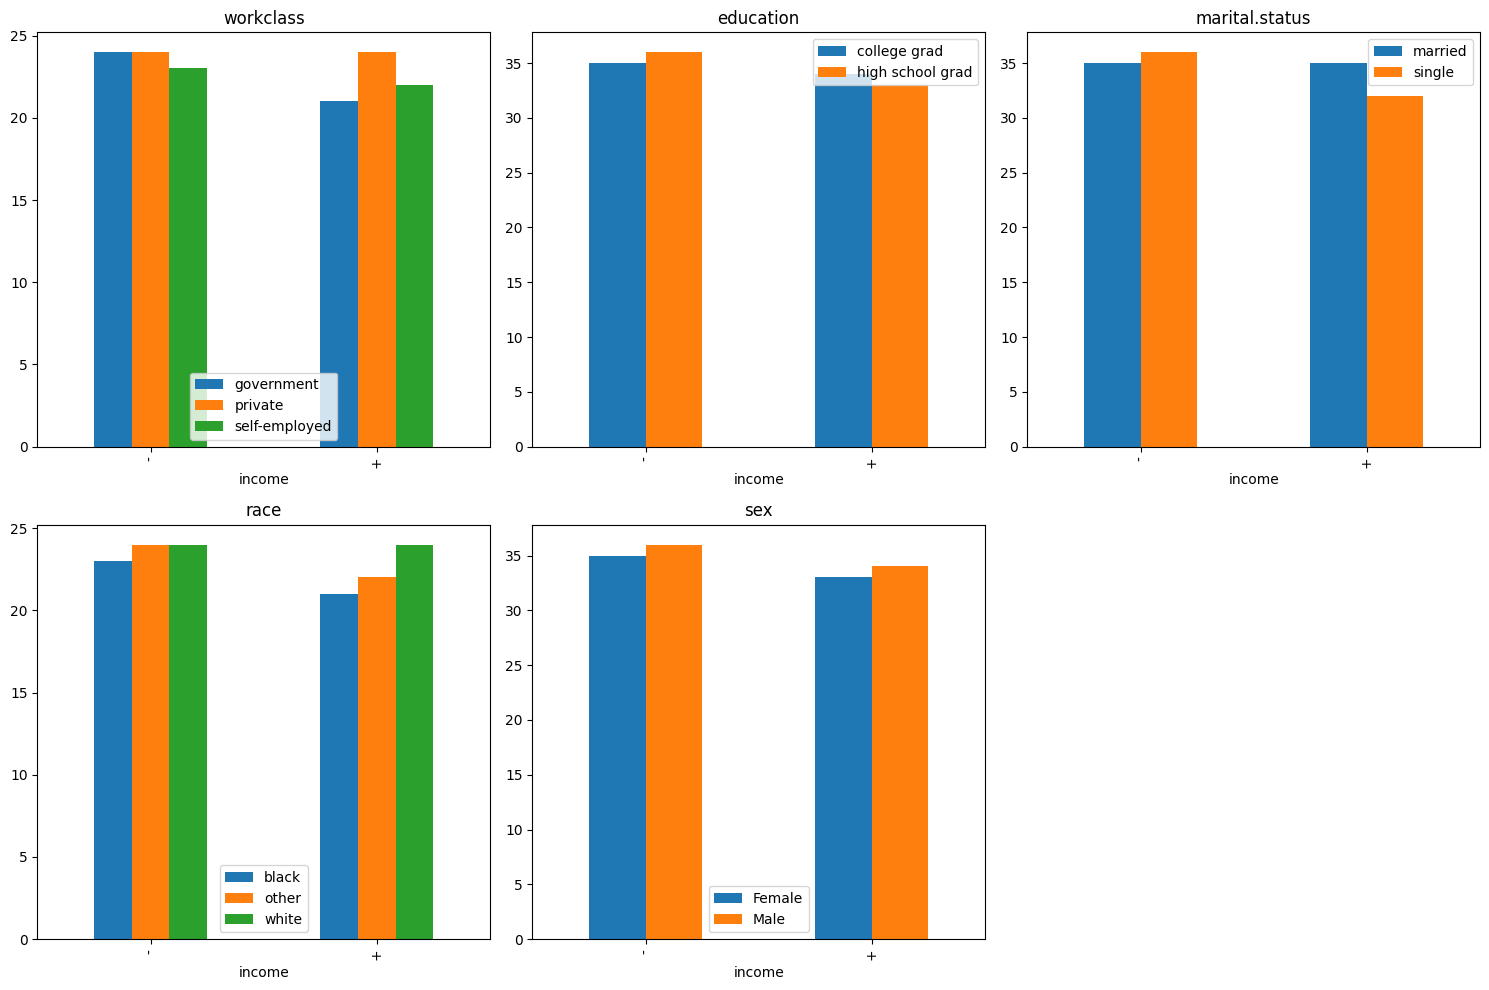

In [14]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()
for i in range(new_data.shape[1] - 1):
    df_2dhist = pd.DataFrame({
        x_label: grp['income'].value_counts()
        for x_label, grp in new_data.groupby(new_data.columns[i])
    })
    df_2dhist.plot.bar(ax=axes[i])
    axes[i].set_title(new_data.columns[i])
for i in range(new_data.shape[1] - 1, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [15]:
max_hypothesis = []
for column in new_data.columns:
    max_hypothesis.append(np.unique(new_data[column]))
    print(np.unique(new_data[column]))

['government' 'private' 'self-employed']
['college grad' 'high school grad']
['married' 'single']
['black' 'other' 'white']
['Female' 'Male']
['+' '-']


In [38]:
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

In [16]:
train_data, train_labels = new_data.values[:8, :-1], new_data.values[:8, -1]
val_data, val_labels = new_data.values[[9, 10], :-1], new_data.values[[9, 10], -1]

In [79]:
val_data

array([['private', 'college grad', 'single', 'black', 'Male'],
       ['private', 'college grad', 'married', 'white', 'Male']],
      dtype=object)

# models

## Rote Learning

In [45]:
rl = RoteLearning()
rl.fit(train_data, train_labels)

In [46]:
pred_labels = rl.predict(val_data)
print("predicted Labels: ", pred_labels)
print("accuracy for Rote Learning: ", accuracy(pred_labels,val_labels))

predicted Labels:  [None, None]
accuracy for Rote Learning:  0.0


## FindS

In [19]:
fs = FindS()
fs.fit(train_data, train_labels)

In [41]:
pred_labels = fs.predict(val_data)
print("predicted Labels: ", pred_labels)
print("accuracy for Find-S: ", accuracy(pred_labels,val_labels))

predicted Labels:  ['+' '-']
accuracy for Find-S:  1.0


In [23]:
fs.h

array(['?', 'college grad', 'single', '?', '?'], dtype='<U12')

## CandidElimination

In [24]:
ce = CandidElimination(fs)
ce.fit(train_data, train_labels)

In [40]:
pred_labels = ce.predict(val_data)
print("predicted Labels: ", pred_labels)
print("accuracy for Candid ELimination: ", accuracy(pred_labels,val_labels))

predicted Labels:  ['+' None]
accuracy for Candid ELimination:  0.5


In [25]:
ce.status

'consistent'

In [26]:
ce.specific

array(['?', 'college grad', 'single', '?', '?'], dtype='<U12')

In [27]:
ce.general

array([['?', 'college grad', '?', '?', '?']], dtype='<U12')

In [36]:
query_sample = np.array([['private', 'college grad', 'married', 'white', 'Male']])
ce.predict(query_sample)

array([None], dtype=object)

## ListThanElimination

In [43]:
lte = ListThenEliminate()
lte.fit(train_data, train_labels)

In [44]:
pred_labels = lte.predict(val_data)
print("predicted Labels: ", pred_labels)
print("accuracy for List than Elimination: ", accuracy(pred_labels,val_labels))

predicted Labels:  ['+' None]
accuracy for List than Elimination:  0.5


In [85]:
lte.vs

array([['?', 'college grad', 'single', '?', '?'],
       ['?', 'college grad', '?', '?', '?']], dtype='<U16')

## random

In [72]:
np.random.seed(0)
ind = np.random.choice(len(new_data), 8, replace = False)
random_data, random_labels = new_data.values[ind, :-1], new_data.values[ind, -1]

In [80]:
fs.h

array(['?', 'college grad', 'single', '?', '?'], dtype='<U12')

In [73]:
random_data

array([['private', 'high school grad', 'single', 'white', 'Male'],
       ['private', 'high school grad', 'married', 'black', 'Male'],
       ['self-employed', 'high school grad', 'married', 'white',
        'Female'],
       ['self-employed', 'college grad', 'married', 'white', 'Female'],
       ['private', 'college grad', 'married', 'white', 'Female'],
       ['self-employed', 'high school grad', 'single', 'white', 'Male'],
       ['private', 'college grad', 'married', 'black', 'Male'],
       ['private', 'college grad', 'married', 'other', 'Female']],
      dtype=object)

In [74]:
random_labels

array(['+', '+', '+', '-', '+', '-', '-', '+'], dtype=object)

In [75]:
rl_predicted = rl.predict(random_data)
print("predicted Labels: ", rl_predicted)
print("Rote learning accuracy", accuracy(random_labels, rl_predicted))

predicted Labels:  ['-', None, None, None, None, None, None, None]
Rote learning accuracy 0.0


In [76]:
fs_predicted = fs.predict(random_data)
print("predicted Labels: ", fs_predicted)
print("Find_S accuracy", accuracy(random_labels, fs_predicted))

predicted Labels:  ['-' '-' '-' '-' '-' '-' '-' '-']
Find_S accuracy 0.375


In [77]:
ce_predicted = ce.predict(random_data)
print("predicted Labels: ", ce_predicted)
print("Candidate Elimination accuracy", accuracy(random_labels, ce_predicted))

predicted Labels:  ['-' '-' '-' None None '-' None None]
Candidate Elimination accuracy 0.125


In [78]:
lte_predicted = lte.predict(random_data)
print("predicted Labels: ", lte_predicted)
print("List Then Eliminate accuracy", accuracy(random_labels, lte_predicted))

predicted Labels:  ['-' '-' '-' None None '-' None None]
List Then Eliminate accuracy 0.125
